# Multiple support excitation za nosač jednoga raspona

<h1 id="tocheading">Sadržaj</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Skice

### Skica diskretiziranog nosača na četiri konačna elementa

Ovdje za primjer je dana prosta greda iako je moguće koristiti proračun s drugačijim rubnim uvjetima. Na skici je primjer bez dodatnih masa od utega.

<img src="model 7 masa.png" width="600" height="225" />

## Korištena literatura

~~~ ubaciti link

## Paketi korišteni u proračunu

In [2]:
%matplotlib inline

In [3]:
import numpy as np
from scipy import linalg as la
import matplotlib.pyplot as plt

## Ulazni podaci

In [4]:
n_primjer = 3 # broj konačnih elemenata 
l = 2.0 # [m]
h, b = 0.013, 0.040 # [m]
I = b * h**3 / 12 # [m^4]
E = 12.5 * 10**9 # [N/m^2]
m_uk = 0.650 * 7/8 # [kg] ~~~ 7/8 jer je greda razrezana s 2.40 m na 2.10 m
#m_uteg = ...
ksi = 0.05 # vidjeti u eksperimentu
delta_t = 0.02 #[sec] korak u proračunu
delay_t_primjer = 5.0 #[sec] kašnjenje potresnog signala
r_u_l_primjer = "u" # rubni uvjet lijevo je upeti ležaj
r_u_d_primjer = "z" # rubni uvjet desno je zglobni ležaj

## Napomene ~~i pitanja(boldano)~~:

- ukoliko se kasnije zakomplicira proracun moguce je promijeniti matrice iz dense u sparse (sp.diag) na str. 240 knjige approach for industry

- veći utjecaj ima tuple unpacking..

- možda osim funkcija ubaciti i interact za varijable s indeksom "_primjer" (što zasada ne radi online)

- Ubaciti prva tri tona na graf!

- u funkciji def M(n) se masa ukupno m_uk dijeli na n+1 dijelova potrebna provjera (slika ne odgovara), masa koja ulazi u proračun će biti $m_{uk} / (n-1)$ , a ne $m_{uk} / n$

- potrebno je ubaciti dodatne mase m_uteg u matricu masa

- potrebno izračunati ksi iz optičkih mjerenja

- ubaciti link za literaturu (pitati prof. Bićanića)

- u obradu potresnih zapisa je ubačena interpolacija koja dozvoljava precizniji proračun u slučaju korištenja manjeg vremenskog koraka

- potresna ekscitacija se ostvaruje i na kutevima zaokreta, iako funkcija Gama sugerira da neće postojati ekscitacija kod kuteva zaokreta. "Problem" nastaje radi kašnjenja signala - vjerovatno procedura daje dobre rezultate.

In [5]:
# rezultati će svugdje biti zaokruženi na 2 decimale
np.set_printoptions(precision=2)

## Matrica masa

Ovaj korak u literaturi je nazvan Step 1. ~~Koristi se lumped mass model - statički spregnuti sustav.~~ Cjelokupna matrica masa ovako izgleda:

$$\begin{bmatrix}
    M_{ss} & M_{sg}\\
    M_{gs} & M_{gg}\\
\end{bmatrix}$$

gdje su:

- $M$ - cjelokupna matrica krutosti

- $M_{ss}$ - matrica masa konstrukcije (eng. "super structure/ non-support degree of freedom")

- $M_{sg}, M_{gs}, M_{gg}$ - matrice masa s masama uz oslonce (eng. "support degree of freedom")

U poglavlju Rubni uvjeti se definira matrica masa konstrukcije M_ss iz matrice M_osn. M_osn je osnovna matrica masa koja je ekvivalenta cjelokupnoj osim u razmještaju redaka i stupaca:

In [6]:
def M_osn(n):
    """Assembly osnovne matrice masa ovisno o broju konačnih elemenata n.
    Kutevima zaokreta se pridružuju zanemarive mase što je nužno radi
    kasnijeg inverza ove funkcije."""
    return np.diag((m_uk/(n+1),m_uk/(n+1)/1000)*(n+1))
print(M_osn(n_primjer))

[[ 0.14  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.14  0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.14  0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.14  0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]]


## Matrica krutosti

Ovaj korak u literaturi je nazvan Step 2. U poglavlju Rubni uvjeti se definiraju matrice krutosti potrebne za proračun iz cjelokupne matrice masa. Cjelokupna matrica krutosti ovako izgleda:

$$\begin{bmatrix}
    K_{ss} & K_{sg}\\
    K_{gs} & K_{gg}\\
\end{bmatrix}$$

gdje su:

- $K$ - cjelokupna matrica krutosti

- $K_{ss}$ - statička matrica krutosti konstrukcije (eng. "super structure/ non-support degree of freedom")

- $K_{sg}, K_{gs}, K_{gg}$ - matrice krutosti s krutostima oslonaca (eng. "support degree of freedom")

### Matrica krutosti jednog konačnog elemenata

Koristi se inženjerska matrica krutosti. U kodu je pod imenom K_1, a donja tablica daje prikaz iste u simboličnom obliku.

$$\begin{bmatrix}
    \frac{12 E I}{l^3} & \frac{6 E I}{l^2} & \frac{-12 E I}{l^3} & \frac{6 E I}{l^2} \\
    \frac{6 E I}{l^2} & \frac{4 E I}{l} & \frac{-6 E I}{l^2} & \frac{2 E I}{l} \\
    \frac{-12 E I}{l^3} & \frac{-6 E I}{l^2} & \frac{12 E I}{l^3} & \frac{-6 E I}{l^2} \\
    \frac{6 E I}{l^2} & \frac{2 E I}{l} & \frac{-6 E I}{l^2} & \frac{4 E I}{l} \\
\end{bmatrix}$$

In [7]:
def K_1(n):
    return np.array([[12*E*I/(l/n)**3, 6*E*I/(l/n)**2, -12*E*I/(l/n)**3, 6*E*I/(l/n)**2],
                    [6*E*I/(l/n)**2, 4*E*I/(l/n), -6*E*I/(l/n)**2, 2*E*I/(l/n)],
                    [-12*E*I/(l/n)**3, -6*E*I/(l/n)**2, 12*E*I/(l/n)**3, -6*E*I/(l/n)**2],
                    [6*E*I/(l/n)**2, 2*E*I/(l/n), -6*E*I/(l/n)**2, 4*E*I/(l/n)]])
print(K_1(n_primjer))

[[ 3707.44  1235.81 -3707.44  1235.81]
 [ 1235.81   549.25 -1235.81   274.63]
 [-3707.44 -1235.81  3707.44 -1235.81]
 [ 1235.81   274.63 -1235.81   549.25]]


### Slaganje mreže konačnih elemenata (assembly)

Radi preglednosti i ovdje su dana objašnjenja matrica krutosti:

- K_osn - osnovna matrica krutosti

- K - cjelokupna matrica krutosti koja je ekvivalentna osnovnoj osim u razmestaju redaka i stupaca (nije potrebna za proracun)

- K_ss - statička matrica krutosti konstrukcije $K_{ss}$ (eng. "super structure/ non-support degree of freedom")

- K_sg - matrica krutosti s krutostima oslonaca $K_{sg}$ (eng. "support degree of freedom") koja je potrebna za proracun

- K_gs, K_gg -  ostale matrice krutosti s krutostima oslonaca (eng. "support degree of freedom")

In [8]:
def K_osn(n):
    """Assembly osnovne matrice krutosti ovisno o broju konačnih elemenata n"""
    pomocna_matrica = np.zeros((2*(n+1), 2*(n+1))) # iniciranje nul - matrice
    for i in range(n):
        pomocna_matrica[2*i:2*i+4, 2*i:2*i+4] += K_1(n) 
    return pomocna_matrica
print(K_osn(n_primjer))

[[ 3707.44  1235.81 -3707.44  1235.81     0.       0.       0.       0.  ]
 [ 1235.81   549.25 -1235.81   274.63     0.       0.       0.       0.  ]
 [-3707.44 -1235.81  7414.88     0.   -3707.44  1235.81     0.       0.  ]
 [ 1235.81   274.63     0.    1098.5  -1235.81   274.63     0.       0.  ]
 [    0.       0.   -3707.44 -1235.81  7414.88     0.   -3707.44  1235.81]
 [    0.       0.    1235.81   274.63     0.    1098.5  -1235.81   274.63]
 [    0.       0.       0.       0.   -3707.44 -1235.81  3707.44 -1235.81]
 [    0.       0.       0.       0.    1235.81   274.63 -1235.81   549.25]]


## Rubni uvjeti

Ovaj korak nije naveden u koracima literature, a potreban je za generalizaciju proračuna. Ideja je da se za svaku kombinaciju rubnih uvjeta izvrše potrebna premještanja redaka i stupaca ili brisanje istih. Time se dobiju matrice $K_{ss}$, $K_{sg}$ i $M_{ss}$ koje su potrebne za proracun. Rubni uvjeti se definiraju kao "u" za upeti oslonac i kao "z" za zglobni oslonac.
- r_u_l - rubni uvjet na lijevom osloncu 
- r_u_d - rubni uvjet na desnom osloncu
- K_ss - statička matrica krutosti konstrukcije (super structure/ non-support degree of freedom) $K_{ss}$
- K_sg - matrica krutosti s krutosti oslonaca (support degree of freedom) $K_{sg}$
- M_ss - matrica masa konstrukcije (eng. "super structure/ non-support degree of freedom") $M_{ss}$

In [9]:
def premjestanje(i):
    """
    Pomocna funkcija koja daje listu i po kojoj se premjestaju 
    retci i stupci osnovne matrice krutosti
    """
    return np.argsort(np.argsort(i)) # najbrzi nacin za mali broj konacnih elemenata

def rubni_uvjeti(n, r_u_l, r_u_d):
    """
    Uvrštavanje rubnih uvjeta u matricu krutosti ovisi o broju konačnih elemenata 
    te o rubnim uvjetima.
    Prvo se definira sort lista koja daje indekse s novim poretkom redaka i stupaca 
    matrice krutosti. Ovisno o rubnim uvjetima argumenti arg daju drukcije indekse. 
    Nadalje, mijenjaju se retci i stupci te se odvoje matrice K_ss i K_sg 
    od osnovne matrice krutosti. Slicnom logikom se od cjelokupne matrice masa M odvoji
    matrica masa konstrukcije M_ss.
    """
    if r_u_l == "u" and r_u_d == "u":
        sort = premjestanje([arg for arg in range(2,2*(n+1)-2)] + [0,1,2*(n+1)-1,2*(n+1)])
        K = K_osn(n)[:,sort] # zamjena stupaca na osnovnoj matrici krutosti
        K = K[sort,:] # zamjena redaka
        K_ss = K[0:-4, 0:-4]
        K_sg = K[0:-4, -4:]
        M_ss = M_osn(n)[2:2*(n+1)-2, 2:2*(n+1)-2]
    elif r_u_l == "z" and r_u_d == "z":
        sort = premjestanje([arg for arg in range(1,2*(n+1)-2)] + [2*(n+1),0,2*(n+1)-1])
        K = K_osn(n)[:,sort] # zamjena stupaca na osnovnoj matrici krutosti
        K = K[sort,:] # zamjena redaka
        K_ss = K[0:-2,0:-2]
        K_sg = K[0:-2,-2:]
        M_ss = np.delete(M_osn(n),(0,2*(n+1)-2),0) # brisanje redaka osnovne matrice masa
        M_ss = np.delete(M_ss,(0,2*(n+1)-2),1) # brisanje stupaca
    elif r_u_l == "u" and r_u_d == "z":
        sort = premjestanje([arg for arg in range(2,2*(n+1)-2)] + [2*(n+1),0,1,2*(n+1)-1])
        K = K_osn(n)[:,sort] # zamjena stupaca na osnovnoj matrici krutosti
        K = K[sort,:] # zamjena redaka
        K_ss = K[0:-3,0:-3]
        K_sg = K[0:-3,-3:]
        M_ss = np.delete(M_osn(n),(0,1,2*(n+1)-2),0) # brisanje redaka osnovne matrice masa
        M_ss = np.delete(M_ss,(0,1,2*(n+1)-2),1) # brisanje stupaca
    elif r_u_l == "z" and r_u_d == "u":
        sort = premjestanje([0] + [arg for arg in range(2,2*(n+1)-2)] + [1,2*(n+1)-1,2*(n+1)])
        K = K_osn(n)[:,sort] # zamjena stupaca na osnovnoj matrici krutosti
        K = K[sort,:] # zamjena redaka
        K_ss = K[0:-3,0:-3]
        K_sg = K[0:-3,-3:]
        M_ss = np.delete(M_osn(n),(0,2*(n+1)-2,2*(n+1)-1),0) # brisanje redaka osnovne matrice masa
        M_ss = np.delete(M_ss,(0,2*(n+1)-2,2*(n+1)-1),1) # brisanje stupaca
    return (K_ss,K_sg,M_ss)

In [10]:
# K_ss i K_sg matrica za varijable _primjer
rubni_uvjeti(3, "u", "z")[0], rubni_uvjeti(3, "u", "z")[1]

(array([[ 7414.88,     0.  , -3707.44,  1235.81,     0.  ],
        [    0.  ,  1098.5 , -1235.81,   274.63,     0.  ],
        [-3707.44, -1235.81,  7414.88,     0.  ,  1235.81],
        [ 1235.81,   274.63,     0.  ,  1098.5 ,   274.63],
        [    0.  ,     0.  ,  1235.81,   274.63,   549.25]]),
 array([[-3707.44, -1235.81,     0.  ],
        [ 1235.81,   274.63,     0.  ],
        [    0.  ,     0.  , -3707.44],
        [    0.  ,     0.  , -1235.81],
        [    0.  ,     0.  , -1235.81]]))

In [11]:
#Svaki put se poziva cijela funkcija rubni_uvjeti(...). Kako to izbjeci, a da se ne ponavlja tekst
#i ne gubi preglednost?
def K_ss(n, r_u_l, r_u_d):
    return rubni_uvjeti(n, r_u_l, r_u_d)[0]
def K_sg(n, r_u_l, r_u_d):
    return rubni_uvjeti(n, r_u_l, r_u_d)[1]
def M_ss(n, r_u_l, r_u_d):
    return rubni_uvjeti(n, r_u_l, r_u_d)[2]

# MIRAN: Ovako? ("tuple unpacking")
def uvjeti(n, r_u_l, r_u_d):
    K_ss, K_sg, M_ss = rubni_uvjeti(n, r_u_l, r_u_d)
    # ....

## Proračun vlastitih vrijednosti i kružnih frekvencija

Ovaj korak je u literaturi nazvan Step 3. Bilo bi dobro prepoznati pa dodati vlastite tonove koji bi se onda mogli nacrtati na grafu. Trenutno "smetaju" stupnjevi slobode od kuteva zaokreta.

In [12]:
def w(n, r_u_l, r_u_d):
    """Funkcija w izvodi proracun vlastitih vrijednosti i oblika, a ispisuje kruzne
    frekvencije sustava te odbacuje imaginarni dio +0*i."""
    vlastite_vrijednosti = np.linalg.inv(K_ss(n, r_u_l, r_u_d)).dot(M_ss(n, r_u_l, r_u_d))
    evals, evecs = la.eig(vlastite_vrijednosti)
    evals = evals[evals != 0.0] # brisu se vlastite frekvencije povezane s kutevima zaokreta
    if np.any(np.iscomplex(evals)): # nije debuggirano
        raise ValueError("Kruzne frekvencije imaju imaginarni dio")
    return np.sort(np.sqrt(evals**(-1))).real
    # MIRAN: Ja bih probao koristiti 'try-except' blok, a ne 'if' za ovu provjeru gore

def f(n, r_u_l, r_u_d):
    """Funkcija f poziva funkciju w pa dijeli istu s 2*pi."""
    return (w(n, r_u_l, r_u_d)/(2*np.pi))

# vlastite frekvencije za sustav s 3 konacna elementa, upeti lezaj lijevo i zglobni desno
f(n_primjer, r_u_l_primjer, r_u_d_primjer)

array([  12.63,   37.51,  273.43,  403.08,  503.07])

### Ispis frekvencije prvog tona za različite rubne uvjete. 
Na ordinati je broj konačnih elemenata pa će se moći vidjeti kako rezultati konvergiraju analitičkom s povećanjem broja konačnih elemenata. Prikazat će se rezultati za n skup prirodnih brojeva n = {3,20}.


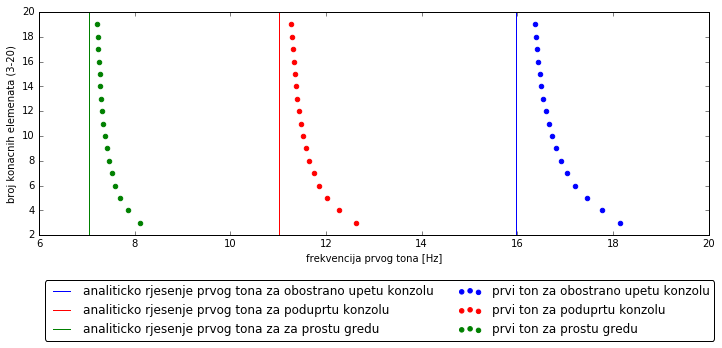

In [13]:
fig, axes = plt.subplots(figsize=(12, 4))
for n_niz in range(3,20):
    axes.scatter(f(n_niz, "u", "u")[0], n_niz, color="blue",
                 label="prvi ton za obostrano upetu konzolu" if n_niz == 3 else "")
    axes.scatter(f(n_niz, "u", "z")[0], n_niz, color="red",
                 label="prvi ton za poduprtu konzolu" if n_niz == 3 else "")
    axes.scatter(f(n_niz, "z", "z")[0], n_niz, color="green",
                 label="prvi ton za prostu gredu" if n_niz == 3 else "")
axes.axvline(15.97, color="blue", 
             label = "analiticko rjesenje prvog tona za obostrano upetu konzolu")
axes.axvline(11.01, color="red", 
             label = "analiticko rjesenje prvog tona za poduprtu konzolu")
axes.axvline(7.05, color="green", 
             label = "analiticko rjesenje prvog tona za za prostu gredu")
axes.set_xlabel("frekvencija prvog tona [Hz]")
axes.set_ylabel("broj konacnih elemenata (3-20)")
axes.legend(loc="lower left", bbox_to_anchor=(0.0, -0.5), fancybox=True, ncol=2)


## Rayleigh-ova matrica prigušenja

Ovaj korak u literaturi je nazvan step 4. Izrazi alfa_0 i alfa_1 postaju izrazito veliki odnosno mali za veliki broj konačnih elemenata. Alfa_0 postaje beskonačno za n=70 (rubni uvjeti kao za _primjer), iako radi nekog razloga matrica prigušenja se i tada može izračunati. 

$$\alpha_0 = \frac{2 \xi \prod_\limits{i=1}^{n-1} \omega_i}{\sum_\limits{i=1}^{n-1} \omega_i}$$

$$\alpha_0 = \frac{2 \xi}{\sum_\limits{i=1}^{n-1} \omega_i}$$

$$C = \alpha_0 M + \alpha_1 K$$

gdje su:

- C - Rayleigh-ova matrica prigušenja

- ...

In [14]:
def alfa(n, r_u_l, r_u_d):
    alfa_1 = 2*ksi/np.sum(w(n, r_u_l, r_u_d))
    alfa_0 = alfa_1*np.prod(w(n, r_u_l, r_u_d))
    return alfa_0, alfa_1
def C(n, r_u_l, r_u_d):
    """Racunanje Rayleigh-ove matrice prigusenja"""
    return (alfa(n_primjer, r_u_l_primjer, r_u_d_primjer)[0] * M_ss(n, r_u_l, r_u_d)
            + alfa(n_primjer, r_u_l_primjer, r_u_d_primjer)[1] * K_ss(n, r_u_l, r_u_d))
C(n_primjer, r_u_l_primjer, r_u_d_primjer)

array([[  4.73e+08,   0.00e+00,  -4.80e-02,   1.60e-02,   0.00e+00],
       [  0.00e+00,   4.73e+05,  -1.60e-02,   3.55e-03,   0.00e+00],
       [ -4.80e-02,  -1.60e-02,   4.73e+08,   0.00e+00,   1.60e-02],
       [  1.60e-02,   3.55e-03,   0.00e+00,   4.73e+05,   3.55e-03],
       [  0.00e+00,   0.00e+00,   1.60e-02,   3.55e-03,   4.73e+05]])

## Matrica utjecajnih koeficijenata $\Gamma$

Ovaj korak u literaturi je nazvan step 5. Za single support excitation i npr. obostrano upetu konzolu, matrica utjecajnih koeficijenata je dimenzija 4x4 , na dijagonali su (1,0,1,0) - nule predstavljaju potresnu ekscitaciju kuteva zaokreta. Single support excitation je ustvari primjer multi support excitation-a gdje su kašnjenja potresnog signala jednaka nuli. Preuzet će se opći postupak kao za multi support excitation, isti je dan u nastavku:

$$\Gamma = -K_{ss}^{-1} K_{sg}$$

In [15]:
def Gama(n, r_u_l, r_u_d):
    return -np.linalg.inv(K_ss(n, r_u_l, r_u_d)).dot(K_sg(n, r_u_l, r_u_d))
Gama(n_primjer, r_u_l_primjer, r_u_d_primjer)#.shape[1]

array([[ 0.85,  0.37,  0.15],
       [-0.42,  0.17,  0.42],
       [ 0.48,  0.3 ,  0.52],
       [-0.67, -0.33,  0.67],
       [-0.75, -0.5 ,  0.75]])

## Potresni zapis

Ovaj korak u literaturi je nazvan step 6. Koristi se stvarni potresni zapis potresa Elcentro preuzet sa stranice http://www.vibrationdata.com/elcentro.dat.



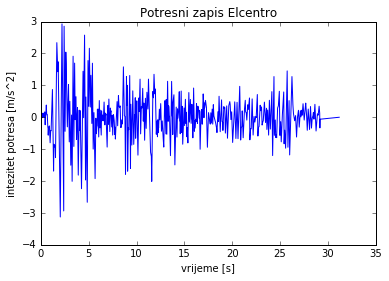

In [16]:
xg = np.fromfile('elcentro.dat', dtype=float, count=-1, sep=' ')
xg_vrijeme_osn = xg[::2] # parne vrijednosti elcentro.dat ~~~ npr. 0,2,4,...
xg_intezitet_osn = xg[1::2] * 9.81 # neparne vrijednosti elcentro.dat ~~~ npr. 1,3,...

fig, axes = plt.subplots()
axes.plot(xg_vrijeme_osn, xg_intezitet_osn)
axes.set_xlabel("vrijeme [s]")
axes.set_ylabel("intezitet potresa [m/s^2]")
axes.set_title("Potresni zapis Elcentro")

### Definiranje kašnjenja potresnog zapisa

Ovisno o r, broju stupaca matrice utjecajnih koeficijenata, se definiraju potresni zapisi za onemogućene/definirane stupnjeve slobode (eng. support degrees of freedom). Način uvođenja varijable r je računski zahtjevan, ali garantira točnost. Varijabla r je broj komponenti ulaznih potresnih signala.

Ispod koda je plot potresnih zapisa. Iz njega se vidi da je definirano da za kuteve zaokreta nema potresne pobude. Proračun koristi prvih 30 sekundi potresnih zapisa pa isti nebi funkcionirao za kraći potresni zapis.


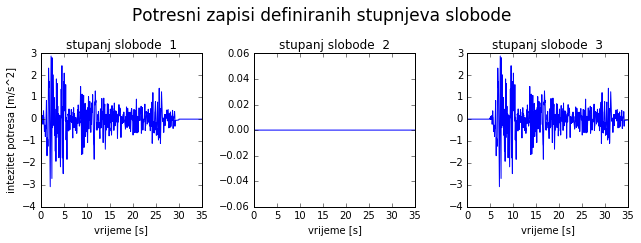

In [17]:
def xg_intezitet(delay_t, r_u_l, r_u_d):
    """Potresni zapis se generalizira odnosno produžuje i uvodi kašnjenje
    za desni oslonac. Varijabla r predstavlja broj stupaca matrice utjecajnih
    koeficijenata odnosno broj definiranih stupnjeva slobode.
    Radi potrebe za smanjenjem vremenskog koraka (problem stabilnosti metode)
    se koristi funkcija np.interp(). Ona linearno intepolira potresni zapis
    te na taj način uvode vrijednosti varijable zapis za manji vremenski korak."""
    r = Gama(n_primjer, r_u_l, r_u_d).shape[1]
    zapis = np.interp(np.linspace(0,30,int(30/delta_t)), 
                      xg_vrijeme_osn[:int(30/xg_vrijeme_osn[1])],
                      xg_intezitet_osn[:int(30/xg_vrijeme_osn[1])])
    xg_intezitet = np.zeros((r, int((30+delay_t)/delta_t))) # iniciranje nul matrice
    xg_intezitet[0,:int(30/delta_t)]= zapis
    if r_u_l == "z":
        xg_intezitet[1,int(delay_t/delta_t):]= zapis
    elif r_u_l == "u":
        xg_intezitet[2,int(delay_t/delta_t):]= zapis   
    return xg_intezitet

#>>> x = np.linspace(0, 2*np.pi, 10)
#>>> y = np.sin(x)
#>>> xvals = np.linspace(0, 2*np.pi, 50)
#>>> yinterp = np.interp(xvals, x, y)

def xg_vrijeme(delay_t):
    return np.array([(0+i*delta_t) for i in range(0, int((30+delay_t)/delta_t))])

def plot_zapisi(delay_t, r_u_l, r_u_d):
    """Plot potresnih zapisa na definirane stupnjeve slobode. Ulazni podaci osim
    kasnjenja su i rubni uvjeti."""
    r = Gama(n_primjer, r_u_l, r_u_d).shape[1]
    fig, axes = plt.subplots(1, r, figsize=(3*r, 3))
    fig.suptitle("Potresni zapisi definiranih stupnjeva slobode", y=1.10, fontsize=17)
    for i in range(r):
        axes[i].plot(xg_vrijeme(delay_t), xg_intezitet(delay_t, r_u_l, r_u_d)[i,:])
        axes[i].set_xlabel("vrijeme [s]")
        axes[i].set_ylabel("intezitet potresa [m/s^2]" if i == 0 else "")
        axes[i].set_title("stupanj slobode  %s"%(i+1))
    plt.tight_layout()
    
plot_zapisi(delay_t_primjer, r_u_l_primjer, r_u_d_primjer)

## Prijelazna matrica

Ovaj korak u literaturi je nazvan step 7. Za računanje dinamičke prijelazne patrice $A_d$ se koristi Pade-ova aproksimacija za matrični eksponent.

Napravljena je preinaka proračuna prikazanog u literaturi, odbacivanje "shear building" pretpostavke te korištenje kuteva zaokreta za stupnjeve slobode. Radi spomenutog, matrica masa $M_{ss}$ je singularna pa "nije moguće" naći inverznu matricu $M_{ss}^{-1}$. Pokušat će se zaobići problem korištenjem Moore-Penrose-ovog pseudoinverza funkcije. Moguće je i pridružiti zanemarive vrijednosti ekscentara masa pa nebi bilo potrebe za pseudoinverzom.

$$A_d = e^{A \Delta t}$$

$$A = \begin{bmatrix}
    0 & I\\
    -M_{ss}^{-1} K_{ss} & -M_{ss}^{-1} C_{ss}\\
\end{bmatrix}$$

In [18]:
def A_A(n, r_u_l, r_u_d):
    """Radi formiranja prijelaznih matrice A i A_d pomoću nested array je potrebno provjeriti
    dimenzije matrica krutosti (odnosno prigušenja i masa) - varijabla dim. """
    dim = K_ss(n, r_u_l, r_u_d).shape[0]
    A_10 = np.dot(-np.linalg.inv(M_ss(n, r_u_l, r_u_d)) , K_ss(n, r_u_l, r_u_d))
    A_11 = np.dot(-np.linalg.inv(M_ss(n, r_u_l, r_u_d)) , C(n, r_u_l, r_u_d))
    A = np.vstack((np.hstack((np.zeros((dim,dim)),np.identity(dim))),np.hstack((A_10,A_11))))
    A_d = la.expm(A*delta_t)
    return A, A_d

def A(n, r_u_l, r_u_d):
    return A_A(n, r_u_l, r_u_d)[0]

def A_d(n, r_u_l, r_u_d):
    return A_A(n, r_u_l, r_u_d)[1]

A(n_primjer, r_u_l_primjer, r_u_d_primjer)

array([[  0.00e+00,   0.00e+00,   0.00e+00,   0.00e+00,   0.00e+00,
          1.00e+00,   0.00e+00,   0.00e+00,   0.00e+00,   0.00e+00],
       [  0.00e+00,   0.00e+00,   0.00e+00,   0.00e+00,   0.00e+00,
          0.00e+00,   1.00e+00,   0.00e+00,   0.00e+00,   0.00e+00],
       [  0.00e+00,   0.00e+00,   0.00e+00,   0.00e+00,   0.00e+00,
          0.00e+00,   0.00e+00,   1.00e+00,   0.00e+00,   0.00e+00],
       [  0.00e+00,   0.00e+00,   0.00e+00,   0.00e+00,   0.00e+00,
          0.00e+00,   0.00e+00,   0.00e+00,   1.00e+00,   0.00e+00],
       [  0.00e+00,   0.00e+00,   0.00e+00,   0.00e+00,   0.00e+00,
          0.00e+00,   0.00e+00,   0.00e+00,   0.00e+00,   1.00e+00],
       [ -5.21e+04,   0.00e+00,   2.61e+04,  -8.69e+03,   0.00e+00,
         -3.33e+09,   0.00e+00,   3.37e-01,  -1.12e-01,   0.00e+00],
       [  0.00e+00,  -7.73e+06,   8.69e+06,  -1.93e+06,   0.00e+00,
          0.00e+00,  -3.33e+09,   1.12e+02,  -2.50e+01,   0.00e+00],
       [  2.61e+04,   8.69e+03,  -5.21e+0

## Vektor stanja

Ovi koraci u literaturi su nazvani step 8 i step 9. Cilj je pronači vektor stanja z. Koristi se multi support računski pristup i za single support excitation. Prvo se izračuna "ulaz" $E_d$ i $E$ prostora stanja (state space). Opet se koristi pseudoinverz, ovog puta za prijelaznu matricu $A^{-1}$.

$$ z_{k+1} = A_d z_k + E_d $$

$$ E_d = A^{-1} (A_d - I) E $$

$$ E = \begin{bmatrix}
    0_{nxr} \\
    - \Gamma {\ddot{x}_g}_{nxr} \\
\end{bmatrix} $$

In [19]:
def E_E(n, r_u_l, r_u_d, delay_t):
    """Definiranje ulaza E i E_d..."""
    dim = K_ss(n, r_u_l, r_u_d).shape[0]
    E_1 = np.vstack(((np.zeros((dim, int((30+delay_t)/delta_t)))),
                   (-Gama(n, r_u_l, r_u_d).dot(xg_intezitet(delay_t, r_u_l, r_u_d))))) 
    E_2 = np.linalg.inv(A(n, r_u_l, r_u_d)).dot(A_d(n, r_u_l, r_u_d) - np.identity(2*dim)).dot(E_1)
    return E_1, E_2

def E_s(n, r_u_l, r_u_d, delay_t):
    """Naziv sugerira E_staticno - u literaturi se koristi oznaka E koja je već zauzeta s
    modulom elastičnosti"""
    return E_E(n, r_u_l, r_u_d, delay_t)[0]

def E_d(n, r_u_l, r_u_d, delay_t):
    return E_E(n, r_u_l, r_u_d, delay_t)[1]

E_d(n_primjer, r_u_l_primjer, r_u_d_primjer, delay_t_primjer)

array([[ -3.19e-13,  -1.84e-13,  -5.03e-14, ...,   3.40e-14,   3.34e-14,
          3.34e-14],
       [  1.50e-13,   8.69e-14,   2.37e-14, ...,   9.49e-14,   9.34e-14,
          9.34e-14],
       [ -1.82e-13,  -1.05e-13,  -2.87e-14, ...,   1.17e-13,   1.16e-13,
          1.16e-13],
       ..., 
       [ -8.94e-12,  -5.16e-12,  -1.41e-12, ...,   5.81e-12,   5.72e-12,
          5.72e-12],
       [  1.24e-11,   7.15e-12,   1.95e-12, ...,   7.47e-12,   7.35e-12,
          7.35e-12],
       [  1.39e-11,   8.04e-12,   2.20e-12, ...,   8.40e-12,   8.27e-12,
          8.27e-12]])

## Dinamička analiza u vremenu (eng. time history) metodom prostora stanja (eng. state space)

Računaju se pomaci, brzine i ubrzanja za svaki vremenski korak delta_t. Ispod je dan proračun metodom prostora stanja. Koriste se praktički sve dosad definirane funkcije. 

Definiranjem funkcije prostor_stanja će se proračun moći pozvat jednom naredbom za: odabrani broj konačnih elemenata, odabrane rubne uvjete te odabrano kašnjenje potresnog signala. 

$$ z_{k+1} = A_d z_k + E_d $$

$$ \dot{z}_{k+1} = A z_k + E $$

$$ z = \begin{bmatrix}
    x \\
    \dot{x} \\
\end{bmatrix} $$

$$ \dot{z} = \begin{bmatrix}
    \dot{x} \\
    \ddot{x} \\
\end{bmatrix} $$

In [20]:
def prostor_stanja(n, r_u_l, r_u_d, delay_t):
    """... Reshape funkcija pretvara vektor s m clanova u matricu m x 1 
    (slicna logika kao u Matlabu). Varijabla xg_sveukupno zbraja inercijalnu
    silu i potresnu silu...."""
    t = delta_t
    i = 1
    dim = K_ss(n, r_u_l, r_u_d).shape[0]
    
    # iniciranje nul matrica :
    z = np.zeros([2*dim,int((30+delay_t)/delta_t)])
    z_dot = z 
    xg_sveukupno = np.zeros([dim,int((30+delay_t)/delta_t)])
    
    # iniciranje "rubnog uvjeta" ubrzanja u trenutku t=0 :
    z_dot[dim:,0] = xg_intezitet_osn[0]
    
    # pomocne varijable - radi preglednosti u petlji :
    A_pom = A(n, r_u_l, r_u_d)
    A_d_pom = A_d(n, r_u_l, r_u_d)
    E_s_pom = E_s(n, r_u_l, r_u_d, delay_t)
    E_d_pom = E_d(n, r_u_l, r_u_d, delay_t)
    xg_intezitet_pom = xg_intezitet(delay_t, r_u_l, r_u_d)
    
    # petlja :
    while t < xg_vrijeme(delay_t)[-2]: # pokusat ubacit i zadnji vrem. korak
        z[:,i:(i+1)] =  A_d_pom.dot(z[:,(i-1):i]) + E_d_pom[:,i-1].reshape(2*dim,1)
        z_dot[:,i:(i+1)] = A_pom.dot(z[:,i:(i+1)]) + E_s_pom[:,i].reshape(2*dim,1)
        xg_sveukupno[:,i] = z_dot[dim:,i] + Gama(n, r_u_l, r_u_d).dot(xg_intezitet_pom[:,i])
        t += delta_t
        i += 1
        
    return z, z_dot, xg_sveukupno

# rjesenje (maknuti # ispod za aktivaciju) :
prostor_stanja(n_primjer, r_u_l_primjer, r_u_d_primjer, delay_t_primjer)[0] #[:,-15:]
# pomaci ~~~ teze beskonacnosti kao i druge vrijednosti iz petlje, greska negdje

array([[  0.00e+00,  -1.58e-11,  -9.13e-12, ...,   1.69e-12,   1.66e-12,
          0.00e+00],
       [  0.00e+00,   7.73e-12,   4.44e-12, ...,   4.75e-12,   4.67e-12,
          0.00e+00],
       [  0.00e+00,  -8.94e-12,  -5.16e-12, ...,   5.91e-12,   5.81e-12,
          0.00e+00],
       ..., 
       [  6.18e-02,   1.26e-02,   1.25e-02, ...,  -3.56e-04,  -3.05e-04,
          0.00e+00],
       [  6.18e-02,  -1.74e-02,  -1.73e-02, ...,  -4.58e-04,  -3.93e-04,
          0.00e+00],
       [  6.18e-02,  -1.96e-02,  -1.95e-02, ...,  -5.15e-04,  -4.42e-04,
          0.00e+00]])

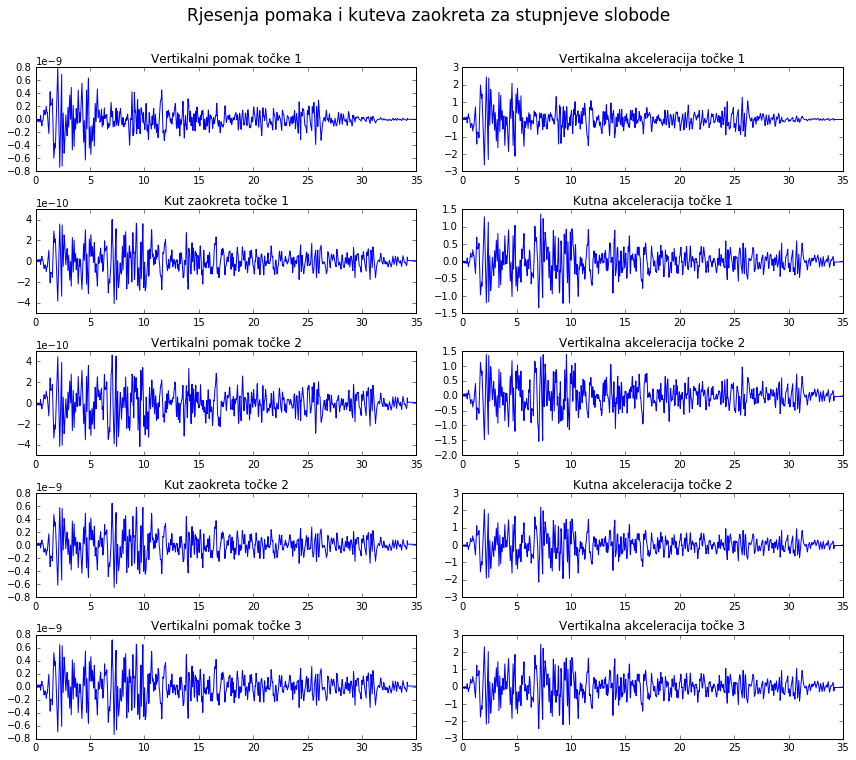

In [21]:
def plot_rjesenja(n, r_u_l, r_u_d, delay_t):
    """Plot... paziti da n ne bude prevelik broj jer ce onda biti previse plotova"""
    dim = K_ss(n, r_u_l, r_u_d).shape[0]
    r = Gama(n_primjer, r_u_l, r_u_d).shape[1]
    pomak = prostor_stanja(n, r_u_l, r_u_d, delay_t)[0][:dim,:]
    akceleracija_uk = prostor_stanja(n, r_u_l, r_u_d, delay_t)[2]
    fig, axes = plt.subplots(dim, 2, figsize = (12,10))
    fig.suptitle("Rjesenja pomaka i kuteva zaokreta za stupnjeve slobode", y=1.05, fontsize=17)
    for i in range(dim):
        axes[i,0].plot(xg_vrijeme(delay_t), pomak[i,:])
        axes[i,1].plot(xg_vrijeme(delay_t), akceleracija_uk[i,:])
        #axes[i].set_xlabel("vrijeme [s]")
        if r_u_l == "z":
            axes[i,0].set_title("Kut zaokreta točke %s"%(i//2+1) if i%2 == 0 
                                else "Vertikalni pomak točke %s"%(i//2+1))
            axes[i,1].set_title("Kutna akceleracija točke %s"%(i//2+1) if i%2 == 0 
                                else "Akceleracija točke %s"%(i//2+1))
        else:
            axes[i,0].set_title("Kut zaokreta točke %s"%(i//2+1) if i%2 == 1 
                                else "Vertikalni pomak točke %s"%(i//2+1))
            axes[i,1].set_title("Kutna akceleracija točke %s"%(i//2+1) if i%2 == 1 
                                else "Vertikalna akceleracija točke %s"%(i//2+1))
    plt.tight_layout()
    
plot_rjesenja(n_primjer, r_u_l_primjer, r_u_d_primjer, delay_t_primjer)

# ne plota dobro naslove u slucaju desnog zgloba... dva zadnja plota trebaju biti kutevi zaokreta